In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.rcParams['text.usetex'] = True
# plt.style.use(['dark_background'])
# plt.style.use('classic')
%matplotlib inline
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
winsize = "2mb"
wdir = "./"
chess_results_file = "ukm_chr2_{}_control_vs_patient_chess_results.tsv".format(winsize)

region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

similarities = pd.read_csv(wdir + chess_results_file, sep='\t', index_col=0)
regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

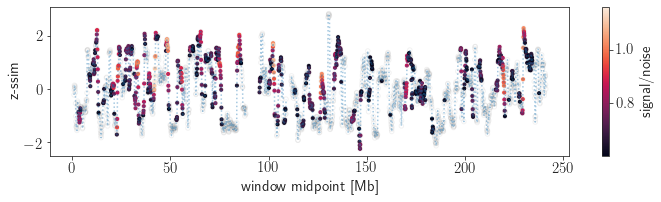

In [5]:
sim_field = "z_ssim"
sn_thr = 0.6
sub_sim = similarities[similarities["SN"] >= sn_thr]

all_X = regions.loc[similarities.index, 1:2].mean(axis=1).values / 10 ** 6

X = regions.loc[sub_sim.index, 1:2].mean(axis=1).values / 10 ** 6
S = sub_sim[sim_field]
SN = sub_sim["SN"]

plt.figure(figsize=(10, 3))
plt.plot(all_X, similarities[sim_field], ":", alpha=0.4)
plt.scatter(all_X, similarities[sim_field], facecolors='none', edgecolors='grey', alpha=0.1, s=20)
plt.scatter(X, S, c=SN, marker='.')
plt.ylabel(sim_field.replace("_", "-"))
plt.xlabel("window midpoint [Mb]")
c = plt.colorbar()
c.set_label("signal/noise")
plt.tight_layout()

In [6]:
similarities[similarities['SN'] >= sn_thr].sort_values("ssim", ascending=True).head(10)

,SN,ssim,z_ssim
ID,,,
1456,0.756514,0.041874,-2.248595
1455,0.738833,0.043831,-2.236625
1454,0.705093,0.063334,-2.117385
1457,0.783688,0.068360,-2.086660
1453,0.664292,0.085979,-1.978934
1452,0.649643,0.123311,-1.750690
1458,0.774973,0.123971,-1.746657
218,0.666028,0.129715,-1.711538
1823,0.608112,0.141477,-1.639621


In [7]:
patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

chr2:144000001-150000001


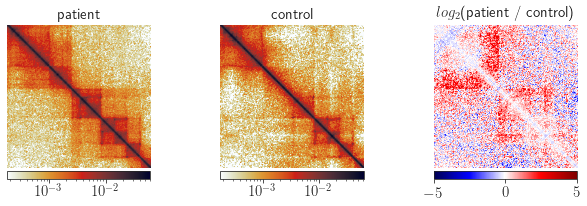

In [8]:
window_start, window_end = regions.loc[1460][1:3]

margin = 2 * 10 ** 6
window_start = int(window_start - margin)
window_end = int(window_end + margin)

region_string = "chr2:{}-{}".format(window_start, window_end)
print(region_string)

# import fanc
patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v

l2fcm = np.log2(patient_region_sub / control_region_sub)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].set_title('patient')
axes[1].set_title('control')
axes[2].set_title('$log_2$(patient / control)')

m1 = axes[0].imshow(patient_region_sub, norm=matplotlib.colors.LogNorm(), cmap='germany')
m2 = axes[1].imshow(control_region_sub, norm=matplotlib.colors.LogNorm(), cmap='germany')
m3 = axes[2].imshow(l2fcm, cmap='seismic', vmax=5, vmin=-5)
for m, ax in zip([m1, m2, m3], axes):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(m, cax=cax, orientation='horizontal')

plt.tight_layout()